# InfoGAN analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from ipywidgets import interact, fixed
import ipywidgets as widgets
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

import pickle

from infogan.models import Generator32, Generator64
from infogan.utils import Code
import interpolation as itp

In [48]:
code = Code(0, 10, 'uniform')
latent_size = 100
z_size = latent_size - code.latent_size

In [51]:
#G = Generator32(latent_size, 64, 1)
#G.load_state_dict(torch.load('results/saved_data/mnist_InfoGAN2_64_generator', map_location=lambda storage, loc: storage))
#G = Generator32(latent_size, 128, 3)
#G.load_state_dict(torch.load('results/saved_data/cifar_InfoGAN_128_generator', map_location=lambda storage, loc: storage))
G = Generator64(latent_size, 128, 3)
G.load_state_dict(torch.load('results/saved_data/paintings64_InfoGAN_128_generator', map_location=lambda storage, loc: storage))
#G = Generator(latent_size, 64, 1)
#G.load_state_dict(torch.load('results/saved_data/mnist_DCGAN_64_generator', map_location=lambda storage, loc: storage))

In [52]:
def sample_z(batch_size, zdim=100):
    return torch.FloatTensor(batch_size, zdim, 1, 1).normal_()

def show_result(z, c=None, G=G):
    
    z = Variable(z, volatile=True)
    if c is not None:
        c = Variable(c, volatile=True)
        samples = G(z,c).data.numpy()
    else:
        samples = G(z).data.numpy()
        
    samples = samples.transpose(0, 2, 3, 1)
    samples = (samples + 1) / 2
    n_samples = samples.shape[0]
    #n_columns = min(n_samples, 10)
    #n_rows = 1 + n_samples//n_columns - (n_samples%n_columns==0)
    
    n_side = int(np.sqrt(n_samples)) + 1 - (n_samples == int(np.sqrt(n_samples))**2)
    fig_side = min(3*n_side, 18)
    
    if n_samples == 1:
        if samples[0].shape[-1] == 1:
            plt.imshow(samples[0].squeeze(), cmap='gray')
        else:
            plt.imshow(samples[0].squeeze())
        return 
    
    fig, ax = plt.subplots(n_side, n_side, figsize=(fig_side, fig_side))
    for i in range(n_side):
        for j in range(n_side):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
            ax[i, j].cla()
            k = i*n_side + j
            if k >= len(samples):
                break
            else:
                if samples[k].shape[-1] == 1:
                    ax[i, j].imshow(samples[k].squeeze(), cmap='gray')
                else:
                    ax[i, j].imshow(samples[k])
    """fig, ax = plt.subplots(n_rows, n_columns, figsize=(18, n_rows*2))
    if n_samples<=n_columns:
        for j in range(n_columns):
            ax[j].get_xaxis().set_visible(False)
            ax[j].get_yaxis().set_visible(False)
            ax[j].cla()
            if samples[j].shape[-1] == 1:
                ax[j].imshow(samples[j].squeeze(), cmap='gray')
            else:
                ax[j].imshow(samples[j])
    else:
        for i in range(n_rows):
            for j in range(n_columns):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
                ax[i, j].cla()
                if samples[i*10+j].shape[-1] == 1:
                    ax[i, j].imshow(samples[i*10+j].squeeze(), cmap='gray')
                else:
                    ax[i, j].imshow(samples[i*10+j])"""
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def show_interpolation(z1, z2, n, mode = 'lerp', G=G):
    z1 = z1.view(1,-1,1,1)
    z2 = z2.view(1,-1,1,1)
    vals = np.linspace(0, 1, n)
    z = torch.Tensor([])
    for v in vals:
        if mode == 'lerp':
            res = itp.lerp(v, z1, z2)
        else:
            z1n = z1.numpy().reshape(-1)
            z2n = z2.numpy().reshape(-1)
            res = itp.slerp(v, z1n, z2n)
            res = torch.Tensor(res).view(1,-1,1,1)
            
        z = torch.cat([z, res],0)
        
    show_result(G, z)
    
def interact_code(code, z=None, latent_size=100, G=G):
    """
    Interactive plot showing the effect of continuous variables in the code.
    Uses a fixed z and the conitnuous variables are set by cursors.
    """
    n_vars = code.n_continuous
    if z is None:
        z = sample_z(1, latent_size-n_vars)
    
    args = {'z':fixed(z)}
    for i in range(n_vars):
        args['c_'+str(i+1)] = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1)
        
    def show_interact(**args):
        c = []
        for i, ci in args.items():
            if i!='z':
                c.append(ci)
            
        c = torch.Tensor(c).view(1,-1,1,1)
        show_result(z,c)
        
    interact(show_interact, **args)
    
def interact_z(dims, z=None, latent_size=100, G=G):
    """
    Displays interactive plot showing the effect of z on the output.
    dims is a list containing the dimensions you want to play with (index starts at 0)
    You can pass a z and, if you don't, one of size latent_size will be sampled at random.
    """
    if z is None:
        z = sample_z(1, latent_size)
    
    args = {'z':fixed(z)}
    for d in dims:
        args[str(d)] = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1)
        
    def show_interact(**args):
        for d, zd in args.items():
            if d != 'z':
                z[0,int(d),0,0] = zd
            
        show_result(z)
        
    interact(show_interact, **args)

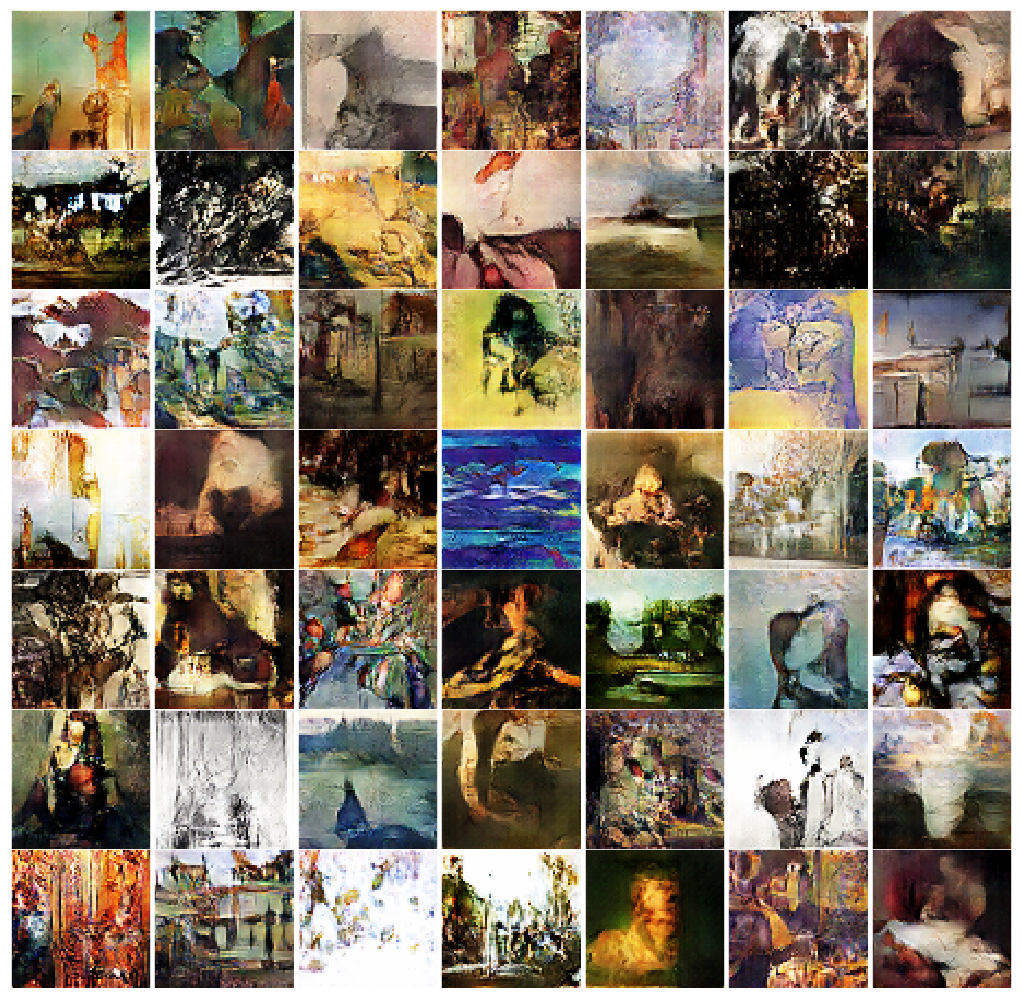

In [46]:
z = sample_z(49, latent_size-code.n_continuous)
c = code.sample_continuous(49)
show_result(z,c)

In [53]:
z = sample_z(1, latent_size - code.n_continuous)
interact_code(code, z=z)

interactive(children=(FloatSlider(value=0.0, description='c_1', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_2', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_3', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_4', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_5', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_6', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_7', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_8', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_9', max=5.0, min=-5.0), FloatSlider(value=0.0, description='c_10', max=5.0, min=-5.0), Output()), _dom_classes=('widget-interact',))

In [31]:
#res = pickle.load(open('results/saved_data/losses_paintings64_InfoGAN_128.p', 'rb'))
res = pickle.load(open('results/saved_data/losses_paintings64_InfoGAN_128.p', 'rb'))

In [32]:
def plot_results(**res):
    plt.figure(figsize=(18,6))
    i = 1
    for label, values in res.items():
        plt.subplot(1,3,i)
        plt.plot(values, label=label)
        plt.legend()
        i+=1
        
    plt.show()

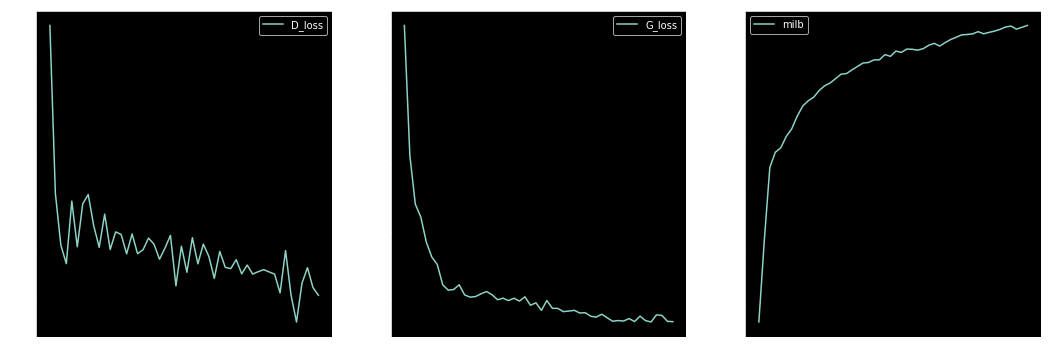

In [33]:
plot_results(**res)